In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import lightning.pytorch as pl

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler , OneHotEncoder

In [26]:
class InsuranceDataModule(pl.LightningDataModule):
    def __init__(self, batch_size : int =8 ):
        super().__init__()
        self.batch_size= batch_size
        
    
    def prepare_data(self) -> None:
        self.insurance_data = pd.read_csv("datasets/insurance.csv")
    
    def setup(self, stage : str = None) -> None:
        X = self.insurance_data.drop(columns = ["charges"])
        y = self.insurance_data["charges"]
        
        if stage == "fit" or stage is None:

            X_train, X_val, y_train, y_val \
                = train_test_split(X, y, test_size = 0.2, random_state = 123)
            
            # Handling categorical features

            categorical_features = ["sex", "smoker", "region"]

            categorical_transformer = OneHotEncoder(handle_unknown = "ignore", \
                drop = "first", sparse_output = False)

            preprocessor = ColumnTransformer( \
                transformers = [("cat_tr", categorical_transformer, categorical_features)],
                remainder = "passthrough")
            
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)

            y_train = y_train.to_numpy()
            y_val = y_val.to_numpy()
            
            # Standardizing numerical features
            stdscaler = StandardScaler()
            X_train = stdscaler.fit_transform(X_train)
            X_val = stdscaler.transform(X_val)
            
            #MinMax Scaling the target variable

            min_max_scaler = MinMaxScaler()
            y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))
            y_val = min_max_scaler.transform(y_val.reshape(-1, 1))
            
            
            self.train_inputs = torch.from_numpy(X_train).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(X_val).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1, 1)).float()
    
    def train_dataloader(self) -> DataLoader:
        train_dataset = TensorDataset(self.train_inputs, self.train_targets)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, shuffle = True, num_workers=6)
        
        return train_loader
    

    
    def val_dataloader(self) -> DataLoader:
        validation_dataset = TensorDataset(self.val_inputs, self.val_targets)
        validation_loader = DataLoader(dataset=validation_dataset, batch_size=self.batch_size, shuffle = False, num_workers=6)
        
        return validation_loader

In [27]:
insurance_dm = InsuranceDataModule()

In [28]:
from lightning.pytorch.utilities.types import OptimizerLRScheduler


class LitRegressionModule(pl.LightningModule):
    def __init__(self, num_features : int, learning_rate : float = .01):
        super().__init__()
        self.layer_1= nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
        self.save_hyperparameters()
        
    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr = self.hparams.learning_rate)
    
    def forward(self, inputs):
        x= self.relu(self.layer_1(inputs))
        x= self.relu(self.layer_2(x))
        x= self.relu(self.layer_3(x))
        x= self.layer_out(x)
        return x
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        output = self.forward(X)
        loss_fn = nn.MSELoss(reduction="mean")
        loss = loss_fn(output, y)  
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        output = self.forward(X)
        loss_fn = nn.MSELoss(reduction="mean")
        loss = loss_fn(output, y)  
        self.log("val_loss", loss, prog_bar=True)  
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        X, y = batch
        output = self.forward(X)
        return output
        
        

In [29]:
model = LitRegressionModule(num_features = 8)

In [31]:
from pytorch_lightning.loggers import CSVLogger
insurance_dm = InsuranceDataModule()
logger = CSVLogger("logs", name="pytorch_lightning_training", version=0)
trainer = pl.Trainer(max_epochs=50, logger=logger)
trainer.fit(model, datamodule=insurance_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jithish/Documents/pytorch-lightning-course/venv/lib/python3.11/site-packages/lightning_fabric/loggers/csv_logs.py:198: Experiment logs directory logs/pytorch_lightning_training/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/jithish/Documents/pytorch-lightning-course/venv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory logs/pytorch_lightning_training/version_0/checkpoints exists and is not empty.

  | Name      | Type   | Params
-------------------------------------
0 | layer_1   | Linear | 144   
1 | layer_2   | Linear | 544   
2 | layer_3   | Linear | 528   
3 | layer_out | Linear | 17    
4 | relu      | ReLU   | 0     
-------------------------------------
1.2 K     Trainable params
0         Non-trainab

Epoch 49: 100%|██████████| 134/134 [00:02<00:00, 47.43it/s, v_num=0, train_loss=0.00294, val_loss=0.00485]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 134/134 [00:02<00:00, 47.31it/s, v_num=0, train_loss=0.00294, val_loss=0.00485]


In [32]:
val_dataloader = insurance_dm.val_dataloader()
prediction = trainer.predict(model=model, dataloaders=val_dataloader)


Predicting DataLoader 0: 100%|██████████| 34/34 [00:00<00:00, 85.44it/s]


In [34]:
prediction

[tensor([[0.2191],
         [0.1155],
         [0.4663],
         [0.1127],
         [0.1478],
         [0.1457],
         [0.0468],
         [0.0817]]),
 tensor([[0.0370],
         [0.1534],
         [0.1011],
         [0.1545],
         [0.1566],
         [0.4351],
         [0.2107],
         [0.4671]]),
 tensor([[0.1577],
         [0.0488],
         [0.6300],
         [0.7361],
         [0.5179],
         [0.8003],
         [0.0256],
         [0.1442]]),
 tensor([[0.0786],
         [0.1670],
         [0.2238],
         [0.0703],
         [0.2245],
         [0.0400],
         [0.1428],
         [0.2673]]),
 tensor([[0.0159],
         [0.0092],
         [0.0716],
         [0.2003],
         [0.2553],
         [0.0336],
         [0.1223],
         [0.1945]]),
 tensor([[0.0913],
         [0.1089],
         [0.0225],
         [0.4979],
         [0.1209],
         [0.0419],
         [0.2087],
         [0.1980]]),
 tensor([[0.2303],
         [0.1034],
         [0.1667],
         [0.1818],


In [36]:
y_pred_stacked = torch.cat(prediction)

y_pred_stacked[:10]

tensor([[0.2191],
        [0.1155],
        [0.4663],
        [0.1127],
        [0.1478],
        [0.1457],
        [0.0468],
        [0.0817],
        [0.0370],
        [0.1534]])

In [37]:
labels = []

for data, label in insurance_dm.val_dataloader():
    labels.extend(label)

In [38]:
y_true = torch.stack(labels)

y_true[:10]

tensor([[0.1412],
        [0.0577],
        [0.5485],
        [0.0651],
        [0.1793],
        [0.1559],
        [0.0603],
        [0.0593],
        [0.0090],
        [0.1340]])

In [39]:
from torchmetrics.regression import R2Score
from torchmetrics.regression import MeanSquaredError

MSE = MeanSquaredError()
r2score = R2Score()

print("Mean Squared Error :", round(MSE(y_pred_stacked, y_true).item(), 3))
print("R^2 :",round(r2score(y_pred_stacked, y_true).item(), 3))

Mean Squared Error : 0.005
R^2 : 0.88


In [40]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics.head(10)

,step,train_loss,epoch,val_loss
0,49,0.022606,0,NaN
1,49,0.014522,0,NaN
2,99,0.011935,0,NaN
3,133,NaN,0,0.037347
4,149,0.040884,1,NaN
5,199,0.029396,1,NaN
6,249,0.035590,1,NaN
7,267,NaN,1,0.034891
8,299,0.044948,2,NaN
9,349,0.006824,2,NaN


,train_loss,val_loss
epoch,,
0,0.022606,NaN
0,0.014522,NaN
0,0.011935,NaN
0,NaN,0.037347
1,0.040884,NaN
1,0.029396,NaN
1,0.035590,NaN
1,NaN,0.034891
2,0.044948,NaN


<Axes: xlabel='epoch'>

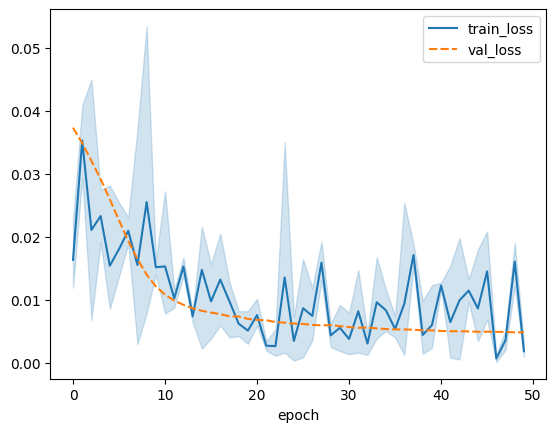

In [41]:
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head(10))

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)